In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout,TimeDistributed,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit

KeyboardInterrupt: 

In [4]:
df = pd.read_csv("C:\\Users\\HP\\Desktop\\LSTM\\merged_eeg_events.csv")

In [5]:
channel_map = {
    "1": "EEG F4-M1",
    "2": "EEG C4-M1",
    "3": "EEG O2-M1",
    "4": "EEG C3-M2",
    "5": "EMG chin",
    "6": "EOG E1-M2",
    "7": "EOG E2-M2",
    "8": "ECG"
}
# เปลี่ยนชื่อ column ใน DataFrame
df = df.rename(columns=channel_map)

# ตรวจสอบ
print(df.head())

       Time  EEG F4-M1  EEG C4-M1  EEG O2-M1  EEG C3-M2  EMG chin  EOG E1-M2  \
0  0.000000  17.126726  14.758526  38.342870   5.896086 -4.528878   3.747616   
1  0.003906  18.225376  15.564202  37.122148   5.456626  1.403830  10.998703   
2  0.007812  17.590600  10.632486  24.109255   7.580682  0.231937  21.643397   
3  0.011719  10.949874   2.941939  13.000687   6.433204 -0.231937  27.405203   
4  0.015625   5.822843   1.647974  18.030060   3.381399  2.868696  26.306554   

   EOG E2-M2        ECG      Annotation  
0  -9.289693  73.719387   Sleep stage W  
1 -10.901045  70.936141   Sleep stage W  
2  -9.509422  69.398032   Sleep stage W  
3 -11.413748  65.149920   Sleep stage W  
4 -14.612039  57.605859   Sleep stage W  


In [6]:
data = df.drop(['Annotation','Time'], axis=1)
labels = df['Annotation']

In [ ]:
# train-test split for time series
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.8)
X_train_df, X_val_df, X_test_df = data[:train_size], data[train_size+1:val_size], data[val_size+1:]
y_train_df, y_val_df, y_test_df = labels[:train_size], labels[train_size+1:val_size], labels[val_size+1:]
X_train_df.shape, X_val_df.shape, X_test_df.shape, y_train_df.shape, y_val_df.shape, y_test_df.shape

ValueError: Input contains NaN

In [12]:
# เช็คและจัดการ NaN
if isinstance(data, pd.DataFrame):
    data = data.fillna(0).values   # แปลงเป็น numpy ด้วย
else:
    data = np.nan_to_num(data, nan=0.0)

if isinstance(labels, pd.Series):
    labels = labels.dropna().values
else:
    labels = np.array(labels)
print("NaN in data:", np.isnan(data).any())
print("NaN in labels:", pd.isna(labels).any())    

NaN in data: False
NaN in labels: False


In [14]:
#ลองแบ่งให้เท่าๆกันทุกคลาส
# -----------------------------
# data = features (numpy array หรือ DataFrame)
# labels = target (numpy array หรือ Series)
# -----------------------------

# make sure same length
min_len = min(len(data), len(labels))
data = np.array(data[:min_len])
labels = np.array(labels[:min_len])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_val_idx, test_idx in sss.split(data, labels):
    X_train_val, X_test = data[train_val_idx], data[test_idx]
    y_train_val, y_test = labels[train_val_idx], labels[test_idx]

# แบ่ง val ออกมาจาก train อีกที
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)  
# 0.25 ของ train_val ≈ 20% ของทั้งหมด

for train_idx, val_idx in sss_val.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

print("Train:", X_train.shape, np.unique(y_train, return_counts=True))
print("Val:", X_val.shape, np.unique(y_val, return_counts=True))
print("Test:", X_test.shape, np.unique(y_test, return_counts=True))


Train: (3935232, 8) (array([' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3',
       ' Sleep stage R', ' Sleep stage W'], dtype=object), array([ 502272, 1981440,  105984,  649728,  695808]))
Val: (1311744, 8) (array([' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3',
       ' Sleep stage R', ' Sleep stage W'], dtype=object), array([167424, 660480,  35328, 216576, 231936]))
Test: (1311744, 8) (array([' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3',
       ' Sleep stage R', ' Sleep stage W'], dtype=object), array([167424, 660480,  35328, 216576, 231936]))


In [15]:
y_train_df.value_counts(), y_val_df.value_counts(), y_test_df.value_counts()

NameError: name 'y_train_df' is not defined

## Sliding window

In [7]:
from imblearn.over_sampling import SMOTE

In [8]:
def apply_sliding_window(data, label, window_size, step_size):
    # Reset index เพื่อให้ iloc ทำงานชัวร์
    data = data.reset_index(drop=True)
    label = label.reset_index(drop=True)

    window_data = []
    window_label = []

    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i:i + window_size]
        label_slice = label.iloc[i:i + window_size]

        if len(label_slice) == 0 or label_slice.mode().empty:
            continue  # ข้าม window ที่ไม่มีข้อมูล

        label_value = label_slice.mode().iloc[0]

        window_data.append(window)
        window_label.append(label_value)

    X = np.array(window_data)
    y = np.array(window_label)
    return X, y

In [9]:
selected_channels = ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1','EEG C3-M2']

# Create the new DataFrame with only the selected channels
X_train_df_reduced = X_train_df[selected_channels]
X_val_df_reduced = X_val_df[selected_channels]
X_test_df_reduced = X_test_df[selected_channels]

X_train_df_reduced.shape, X_val_df_reduced.shape, X_test_df_reduced.shape

((4596480, 4), (656639, 4), (1313279, 4))

In [10]:
# -----------------------------
# 1. ทำ sliding window ก่อน
# -----------------------------
window_size = 400
step_size = 200

X_train, y_train = apply_sliding_window(X_train_df, y_train_df, window_size, step_size)
X_val, y_val     = apply_sliding_window(X_val_df, y_val_df, window_size, step_size)
X_test, y_test   = apply_sliding_window(X_test_df, y_test_df, window_size, step_size)

X_train_reduced, y_train_reduced = apply_sliding_window(X_train_df_reduced, y_train_df, window_size, step_size)
X_val_reduced, y_val_reduced     = apply_sliding_window(X_val_df_reduced, y_val_df, window_size, step_size)
X_test_reduced, y_test_reduced   = apply_sliding_window(X_test_df_reduced, y_test_df, window_size, step_size)

print("Before SMOTE: X_train:", X_train.shape, ", y_train:", y_train.shape)

print("X_train:" ,X_train.shape, ", y_train:", y_train.shape)
print("X_val:" ,X_val.shape, ", y_val:", y_val.shape)
print("X_test:" ,X_test.shape, ", y_test:", y_test.shape)

print("X_train_reduced:" ,X_train_reduced.shape, ", y_train_reduced:", y_train_reduced.shape)
print("X_val_reduced:" ,X_val_reduced.shape, ", y_val_reduced:", y_val_reduced.shape)
print("X_test_reduced:" ,X_test_reduced.shape, ", y_test_reduced:", y_test_reduced.shape)

Before SMOTE: X_train: (22981, 400, 8) , y_train: (22981,)
X_train: (22981, 400, 8) , y_train: (22981,)
X_val: (3282, 400, 8) , y_val: (3282,)
X_test: (6528, 400, 8) , y_test: (6528,)
X_train_reduced: (22981, 400, 4) , y_train_reduced: (22981,)
X_val_reduced: (3282, 400, 4) , y_val_reduced: (3282,)
X_test_reduced: (6528, 400, 4) , y_test_reduced: (6528,)


In [11]:
# 2. Flatten สำหรับ SMOTE
# -----------------------------
nsamples, timesteps, nchannels = X_train.shape
X_train_flat = X_train.reshape((nsamples, timesteps * nchannels))

In [12]:
# -----------------------------
# 3. Oversample ด้วย SMOTE
# -----------------------------
smt = SMOTE(sampling_strategy="auto", random_state=42)
X_train_flat_res, y_train_res = smt.fit_resample(X_train_flat, y_train)

print("After SMOTE: X_train_flat_res:", X_train_flat_res.shape, ", y_train_res:", y_train_res.shape)

After SMOTE: X_train_flat_res: (56550, 3200) , y_train_res: (56550,)


In [13]:
# -----------------------------
# 4. Reshape กลับสำหรับ LSTM
# -----------------------------
X_train_res = X_train_flat_res.reshape((-1, timesteps, nchannels))

print("Final X_train_res shape:", X_train_res.shape, ", y_train_res:", y_train_res.shape)

Final X_train_res shape: (56550, 400, 8) , y_train_res: (56550,)


In [14]:
X_train_df.shape, X_val_df.shape, X_test_df.shape

((4596480, 8), (656639, 8), (1313279, 8))

C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


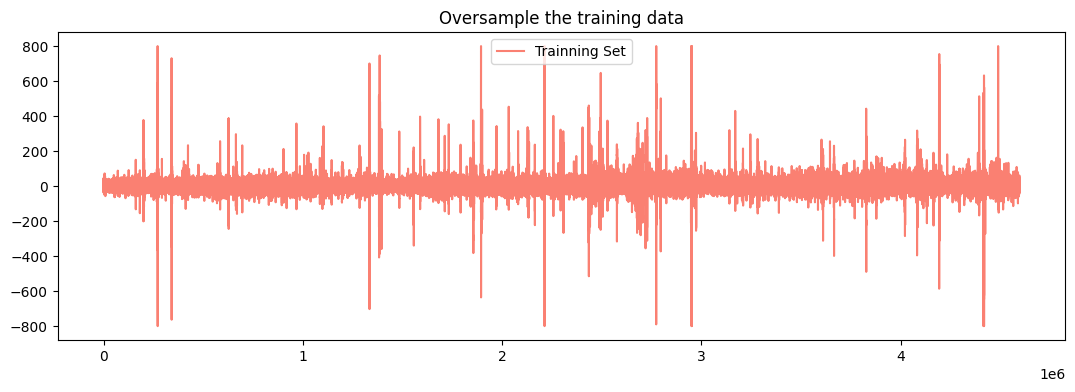

In [15]:
plt.figure(figsize=(13,4))
plt.plot(X_train_df['EEG F4-M1'], color='salmon', label='Trainning Set')
plt.legend()
plt.title('Oversample the training data')
plt.show()

In [16]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596480 entries, 0 to 4596479
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   EEG F4-M1  float64
 1   EEG C4-M1  float64
 2   EEG O2-M1  float64
 3   EEG C3-M2  float64
 4   EMG chin   float64
 5   EOG E1-M2  float64
 6   EOG E2-M2  float64
 7   ECG        float64
dtypes: float64(8)
memory usage: 280.5 MB


Before (original y_train_df):
Annotation
Sleep stage N2    2261760
Sleep stage W      906240
Sleep stage N1     660480
Sleep stage R      629760
Sleep stage N3     138240
Name: count, dtype: int64
After Sliding Window (y_train):
Sleep stage N2    11310
Sleep stage W      4530
Sleep stage N1     3305
Sleep stage R      3149
Sleep stage N3      687
Name: count, dtype: int64
After Sliding Window (selected channels y_train_reduced):
Sleep stage N2    11310
Sleep stage W      4530
Sleep stage N1     3305
Sleep stage R      3149
Sleep stage N3      687
Name: count, dtype: int64
                 Before  After_Full  After_Selected
Sleep stage N2  2261760       11310           11310
Sleep stage W    906240        4530            4530
Sleep stage N1   660480        3305            3305
Sleep stage R    629760        3149            3149
Sleep stage N3   138240         687             687


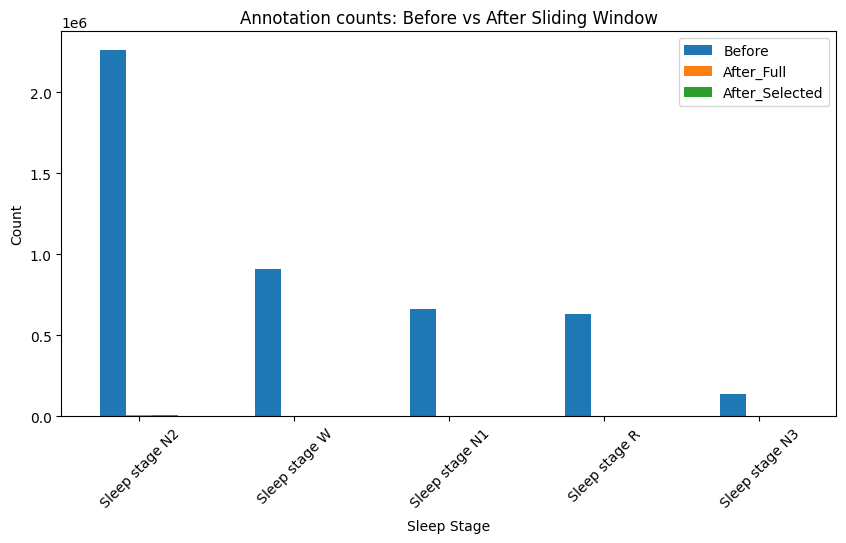

In [17]:
print("Before (original y_train_df):")
print(y_train_df.value_counts())
print("After Sliding Window (y_train):")
print(pd.Series(y_train).value_counts())
print("After Sliding Window (selected channels y_train_reduced):")
print(pd.Series(y_train_reduced).value_counts())
# รวมผลเป็น DataFrame เพื่อเทียบง่าย ๆ
annotation_check = pd.DataFrame({
    "Before": y_train_df.value_counts(),
    "After_Full": pd.Series(y_train).value_counts(),
    "After_Selected": pd.Series(y_train_reduced).value_counts()
}).fillna(0).astype(int)

print(annotation_check)
annotation_check.plot(kind="bar", figsize=(10, 5))
plt.title("Annotation counts: Before vs After Sliding Window")
plt.ylabel("Count")
plt.xlabel("Sleep Stage")
plt.xticks(rotation=45)
plt.show()


In [18]:
print("Before (%):")
print(y_train_df.value_counts(normalize=True) * 100)

print("\nAfter Sliding Window (%):")
print(pd.Series(y_train).value_counts(normalize=True) * 100)


Before (%):
Annotation
Sleep stage N2    49.206349
Sleep stage W     19.715957
Sleep stage N1    14.369256
Sleep stage R     13.700919
Sleep stage N3     3.007519
Name: proportion, dtype: float64

After Sliding Window (%):
Sleep stage N2    49.214569
Sleep stage W     19.711936
Sleep stage N1    14.381446
Sleep stage R     13.702624
Sleep stage N3     2.989426
Name: proportion, dtype: float64


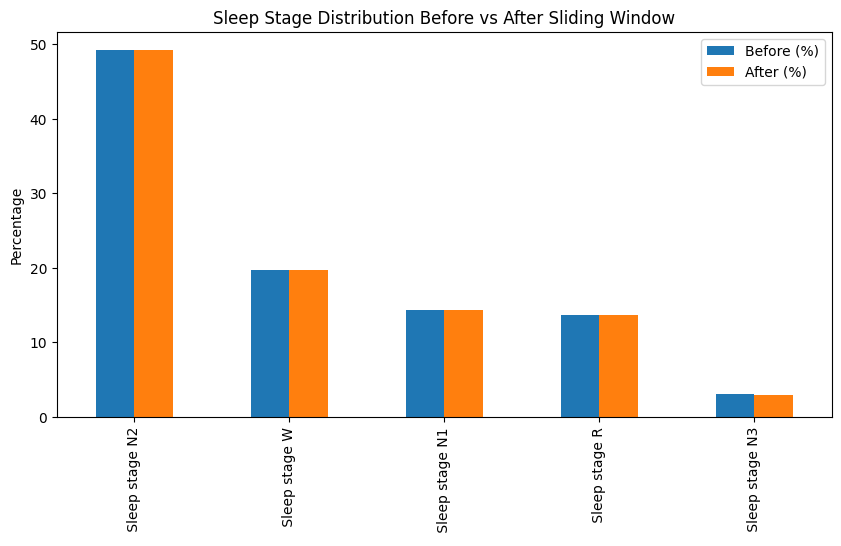

In [19]:
before = y_train_df.value_counts(normalize=True) * 100
after = pd.Series(y_train).value_counts(normalize=True) * 100

compare_df = pd.DataFrame({'Before (%)': before, 'After (%)': after}).fillna(0)

compare_df.plot(kind='bar', figsize=(10,5))
plt.title("Sleep Stage Distribution Before vs After Sliding Window")
plt.ylabel("Percentage")
plt.show()

## Train

### CNN2D แบบสุดโหด

In [20]:
import numpy as np
from scipy.signal import spectrogram
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [28]:


# -----------------------------
# 1. Compute spectrogram function
# -----------------------------
def compute_spectrogram(signal, fs=100, nperseg=128, noverlap=64):
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=min(nperseg, len(signal)), 
                            noverlap=min(noverlap, len(signal)//2))
    return np.log1p(Sxx)

# -----------------------------
# 2. Transform X_train, X_val, X_test → Spectrogram
# -----------------------------
def dataset_to_spectrogram(X, fs=100, nperseg=128, noverlap=64):
    specs = []
    for x in X:  # x.shape = (timesteps, channels)
        ch_specs = [compute_spectrogram(x[:, ch], fs, nperseg, noverlap) 
                    for ch in range(x.shape[1])]
        specs.append(np.stack(ch_specs, axis=-1))  # (freq_bins, time_bins, channels)
    return np.array(specs)

# เพิ่ม channel dimension (เหมือนภาพขาวดำ)
# แปลง dataset ทั้งหมด
X_train_spec = dataset_to_spectrogram(X_train)
X_val_spec   = dataset_to_spectrogram(X_val)
X_test_spec  = dataset_to_spectrogram(X_test)

print("X_train_spec:", X_train_spec.shape)
print("X_val_spec:", X_val_spec.shape)
print("X_test_spec:", X_test_spec.shape)





X_train_spec: (22981, 65, 5, 8)
X_val_spec: (3282, 65, 5, 8)
X_test_spec: (6528, 65, 5, 8)


In [ ]:
# -----------------------------
# 3. Encode labels
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 4. CNN Model (simple)
# -----------------------------
model_cnn_spec = Sequential([
    Conv2D(32, (3,3), activation='relu',padding='same', input_shape=X_train_spec.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2,2),padding='same',),

    Conv2D(64, (3,3), activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2),padding='same'),

    Conv2D(128, (3,3), activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2),padding='same'),

    Conv2D(64, (3,3), activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2),padding='same'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax',)
])

model_cnn_spec.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_cnn_spec.summary()


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 65, 5, 32)      │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 65, 5, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 33, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 33, 3, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 33, 3, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 17, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 17, 2, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 17, 2, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 9, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 9, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 9, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,365 (825.64 KB)

 Trainable params: 210,789 (823.39 KB)

 Non-trainable params: 576 (2.25 KB)

In [45]:
# -----------------------------
# 5. Train model (no class weight)
# -----------------------------
history = model_cnn_spec.fit(
    X_train_spec, y_train_cat,
    validation_data=(X_val_spec, y_val_cat),
    epochs=80,
    batch_size=32,
    shuffle=True
)

Epoch 1/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7420 - loss: 0.7083 - val_accuracy: 0.8821 - val_loss: 0.5745
Epoch 2/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8058 - loss: 0.5367 - val_accuracy: 0.1587 - val_loss: 1.9663
Epoch 3/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8230 - loss: 0.4757 - val_accuracy: 0.8541 - val_loss: 0.7694
Epoch 4/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8387 - loss: 0.4306 - val_accuracy: 0.8288 - val_loss: 1.0212
Epoch 5/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8517 - loss: 0.4075 - val_accuracy: 0.8806 - val_loss: 0.6618
Epoch 6/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8544 - loss: 0.3904 - val_accuracy: 0.7852 - val_loss: 1.3761
Epoch 7/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8617 - loss: 0.3631 - val_accuracy: 0.6624 - val_loss: 1.2501
Epoch 8/80
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8656 - loss: 0.3465 - val_acc

In [46]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model_cnn_spec.evaluate(X_test_spec, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4602 - loss: 5.6299
Test Loss: 5.6299, Test Accuracy: 46.02%


In [47]:
threshold = 0.5  # set the threshold value
y_pred_prob = model_cnn_spec.predict(X_test_spec)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [48]:
print(encoder.classes_)  # ดูว่ามี 5 คลาสทั้งหมด

[' Sleep stage N1' ' Sleep stage N2' ' Sleep stage N3' ' Sleep stage R'
 ' Sleep stage W']


In [49]:
print(np.sum(y_test_cat, axis=0))  # นับจำนวนตัวอย่างแต่ละคลาส

[ 844. 2265.    0. 2265. 1154.]


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


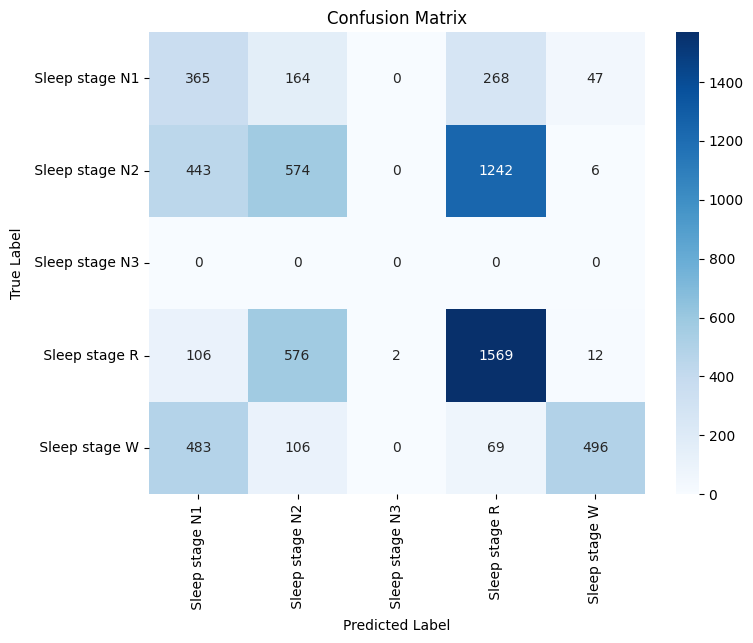

                 precision    recall  f1-score   support

 Sleep stage N1       0.26      0.43      0.33       844
 Sleep stage N2       0.40      0.25      0.31      2265
 Sleep stage N3       0.00      0.00      0.00         0
  Sleep stage R       0.50      0.69      0.58      2265
  Sleep stage W       0.88      0.43      0.58      1154

       accuracy                           0.46      6528
      macro avg       0.41      0.36      0.36      6528
   weighted avg       0.50      0.46      0.45      6528



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [50]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model_cnn_spec.predict(X_test_spec)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
all_labels = [0, 1, 2, 3, 4]
cm = confusion_matrix(y_true, y_pred, labels=all_labels)
# --------------------------
# 3. Plot confusion matrix
# --------------------------

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred,
                            labels=all_labels,
                            target_names=encoder.classes_))

### Convo2D แบบสุดโหด + LSTM

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, GlobalAveragePooling2D, Reshape

In [22]:


# -----------------------------
# 1. Compute spectrogram function
# -----------------------------
def compute_spectrogram(signal, fs=100, nperseg=128, noverlap=64):
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=min(nperseg, len(signal)), 
                            noverlap=min(noverlap, len(signal)//2))
    return np.log1p(Sxx)

# -----------------------------
# 2. Transform X_train, X_val, X_test → Spectrogram
# -----------------------------
def dataset_to_spectrogram(X, fs=100, nperseg=128, noverlap=64):
    specs = []
    for x in X:  # x.shape = (timesteps, channels)
        ch_specs = [compute_spectrogram(x[:, ch], fs, nperseg, noverlap) 
                    for ch in range(x.shape[1])]
        specs.append(np.stack(ch_specs, axis=-1))  # (freq_bins, time_bins, channels)
    return np.array(specs)

# เพิ่ม channel dimension (เหมือนภาพขาวดำ)
# แปลง dataset ทั้งหมด
X_train_spec = dataset_to_spectrogram(X_train)
X_val_spec   = dataset_to_spectrogram(X_val)
X_test_spec  = dataset_to_spectrogram(X_test)

print("X_train_spec:", X_train_spec.shape)
print("X_val_spec:", X_val_spec.shape)
print("X_test_spec:", X_test_spec.shape)





X_train_spec: (22981, 65, 5, 8)
X_val_spec: (3282, 65, 5, 8)
X_test_spec: (6528, 65, 5, 8)


In [26]:
# -----------------------------
# 3. Encode labels
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

freq_bins, time_bins, channels = X_train_spec.shape[1:]

# -----------------------------
# 4. CNN Model (simple)
# -----------------------------
# ---- CNN (extract features from spectrogram) ----
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='same',
                 input_shape=(freq_bins, time_bins, channels)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

# ---- Flatten features along freq axis, keep time axis ----
model.add(TimeDistributed(Flatten()))

# ---- LSTM over time axis ----
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

# ---- Classification ----
model.add(Dense(num_classes, activation='softmax'))

model_cnn_spec.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_cnn_spec.summary()


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'model_cnn_spec' is not defined

In [ ]:
# -----------------------------
# 5. Train model (no class weight)
# -----------------------------
history = model_cnn_spec.fit(
    X_train_spec, y_train_cat,
    validation_data=(X_val_spec, y_val_cat),
    epochs=80,
    batch_size=32,
    shuffle=True
)

In [ ]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model_cnn_spec.evaluate(X_test_spec, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
threshold = 0.5  # set the threshold value
y_pred_prob = model_cnn_spec.predict(X_test_spec)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

In [ ]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model_cnn_spec.predict(X_test_spec)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
all_labels = [0, 1, 2, 3, 4]
cm = confusion_matrix(y_true, y_pred, labels=all_labels)
# --------------------------
# 3. Plot confusion matrix
# --------------------------

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred,
                            labels=all_labels,
                            target_names=encoder.classes_))